In [ ]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the three files
full = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand = parse_graph_info_file('../src/graph_complexity_info_666.txt')
sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')

# 1) Retain only easy/medium from the existing sample (drop hard)
full_keep = full[full['difficulty'].isin(['easy', 'medium'])]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

print("======== Sample Dataset Statistics: ========")
sample_keep = sample[sample['difficulty'].isin(['easy', 'medium'])]
print("sample_keep shape:", sample_keep.shape)

# 2) Compute existing counts
counts = sample_keep['difficulty'].value_counts()
print("Existing sample counts:\n", counts)

# 3) Cohen's d between full and existing sample
def cohens_d(a, b):
    nx, ny = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx = a.var(ddof=1)
    vary = b.var(ddof=1)

    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

print("============= After dropping hard =============")
print("Number of Full Dataset: ", len(full_keep['complexity']))
print("Number of Sample Dataset: ", len(sample_keep['complexity']))

d_initial = cohens_d(full_keep['complexity'], sample_keep['complexity'])
print("\nInitial Cohen's d:", d_initial)

# 4) Determine how many more easy/medium are needed
needed_easy = max(0, 50 - counts.get('easy', 0))
needed_medium = max(0, 64 - counts.get('medium', 0))
print("=========================================")
print(f"Need additional: {needed_easy} easy; {needed_medium} medium")

# 5) Filter candidate pool (exclude already kept)
cand_filtered = cand[~cand['file_path'].isin(sample_keep['file_path'])]
cand_easy = cand_filtered[cand_filtered['difficulty']=='easy']
cand_med  = cand_filtered[cand_filtered['difficulty']=='medium']

# 6) Sort candidates by closeness to full dataset mean complexity
full_mean = full_keep['complexity'].mean()
cand_easy = cand_easy.assign(dist=(cand_easy['complexity'] - full_mean).abs())\
                     .sort_values('dist')
cand_med  = cand_med.assign(dist=(cand_med['complexity']  - full_mean).abs())\
                    .sort_values('dist')

# 7) Greedy selection to best reduce Cohen's d, stopping early if |d|<0.2
remaining = pd.concat([cand_easy, cand_med])
current   = sample_keep.copy()
selected  = pd.DataFrame(columns=current.columns)
stop_flag = False

for diff, needed in [('easy', needed_easy), ('medium', needed_medium)]:
    for _ in range(needed):
        # compute current d and stop if already below threshold
        curr_d = abs(cohens_d(full_keep['complexity'], current['complexity']))
        if curr_d < 0.2:
            print(f"Stopping early: |d|={curr_d:.4f} < 0.2")
            stop_flag = True
            break

        best_idx = None
        best_d   = curr_d

        # try each remaining candidate of this difficulty
        for idx, row in remaining[remaining['difficulty']==diff].iterrows():
            trial = pd.concat([current, pd.DataFrame([row])], ignore_index=True)
            d = abs(cohens_d(full_keep['complexity'], trial['complexity']))
            if d < best_d:
                best_d, best_idx = d, idx

        if best_idx is None:
            print(f"No more {diff} files improve Cohen's d; stopping.")
            stop_flag = True
            break

        # add the best one to current & to selected
        best_row  = remaining.loc[[best_idx]]
        current   = pd.concat([current,  best_row], ignore_index=True)
        selected  = pd.concat([selected, best_row], ignore_index=True)
        remaining = remaining.drop(best_idx)

        # check again after adding
        if best_d < 0.2:
            print(f"Reached |d|={best_d:.4f} < 0.2; stopping early.")
            stop_flag = True
            break

    if stop_flag:
        break

# 8) Output the directories of the selected entries
print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/', 1)[0])
    num += 1

# 9) Verify new Cohen's d
new_sample = pd.concat([sample_keep, selected], ignore_index=True)
d_new = cohens_d(full_keep['complexity'], new_sample['complexity'])
a =full_keep['complexity']
b = new_sample['complexity']
nx, ny = len(a), len(b)
mean_diff = a.mean() - b.mean()
varx = a.var(ddof=1)
vary = b.var(ddof=1)
print("\n================= Data Statistics:================")
print("\nFull Data Statistics:")
print(f"  Count: {nx}")
print(f"  Mean: {a.mean():.4f}")
print(f"  Variance: {varx:.4f}")

print("\nSample Data Statistics:")
print(f"  Count: {ny}")
print(f"  Mean: {b.mean():.4f}")
print(f"  Variance: {vary:.4f}")
print("\nNew Cohen's d:", d_new)


In [15]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the three files
full   = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand   = parse_graph_info_file('../src/graph_complexity_info_662.txt')
sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')

# 1) Retain only easy/medium from the existing sample (drop hard)
full_keep   = full[ full['difficulty'].isin(['easy','medium']) ]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

print("======== Candidate Dataset Statistics: ========")
print("cand shape:", cand.shape)
print("Existing cand counts:\n", cand['difficulty'].value_counts())

print("======== Sample Dataset Statistics: ========")
sample_keep = sample[ sample['difficulty'].isin(['easy','medium']) ]
print("sample_keep shape:", sample_keep.shape)

# 2) Compute existing counts
counts = sample_keep['difficulty'].value_counts()
print("Existing sample counts:\n", counts)

# 3) Cohen's d between full and existing sample
def cohens_d(a, b):
    nx, ny    = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx      = a.var(ddof=1)
    vary      = b.var(ddof=1)
    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

print("============= After dropping hard =============")
print("Number of Full Dataset: ", len(full_keep['complexity']))
print("Number of Sample Dataset: ", len(sample_keep['complexity']))

d_initial = cohens_d(full_keep['complexity'], sample_keep['complexity'])
print("\nInitial Cohen's d:", d_initial)

# 4) Determine how many more easy/medium are needed
needed_easy   = max(0, 50 - counts.get('easy',   0))
needed_medium = max(0, 64 - counts.get('medium', 0))
print("=========================================")
print(f"Need additional: {needed_easy} easy; {needed_medium} medium")

# 5) Filter candidate pool (exclude already kept)
cand_filtered = cand[~cand['file_path'].isin(sample_keep['file_path'])]
cand_easy     = cand_filtered[cand_filtered['difficulty']=='easy']
cand_med      = cand_filtered[cand_filtered['difficulty']=='medium']

# 6) Sort candidates by closeness to full dataset mean complexity
full_mean  = full_keep['complexity'].mean()
cand_easy  = cand_easy.assign(dist=(cand_easy['complexity'] - full_mean).abs())\
                     .sort_values('dist')
cand_med   = cand_med.assign(dist=(cand_med['complexity'] - full_mean).abs())\
                    .sort_values('dist')

# 7) Greedy selection to best reduce Cohen's d, BUT fill all quotas
remaining = pd.concat([cand_easy, cand_med])
current   = sample_keep.copy()
selected  = pd.DataFrame(columns=current.columns)
stop_flag = False

for diff, needed in [('easy', needed_easy), ('medium', needed_medium)]:
    for _ in range(needed):
        # compute current d  (no longer stopping here)
        curr_d = abs(cohens_d(full_keep['complexity'], current['complexity']))
        # if curr_d < 0.2:
        #     print(f"Stopping early: |d|={curr_d:.4f} < 0.2")
        #     stop_flag = True
        #     break

        best_idx = None
        best_d   = curr_d

        # try each remaining candidate of this difficulty
        for idx, row in remaining[remaining['difficulty']==diff].iterrows():
            trial = pd.concat([current, pd.DataFrame([row])], ignore_index=True)
            d = abs(cohens_d(full_keep['complexity'], trial['complexity']))
            if d < best_d:
                best_d, best_idx = d, idx

        if best_idx is None:
            print(f"No more {diff} files improve Cohen's d; stopping.")
            stop_flag = True
            break

        # add the best one to current & to selected
        best_row  = remaining.loc[[best_idx]]
        current   = pd.concat([current,  best_row], ignore_index=True)
        selected  = pd.concat([selected, best_row],  ignore_index=True)
        remaining = remaining.drop(best_idx)

        # check again after adding  (but do NOT break)
        # if best_d < 0.2:
        #     print(f"Reached |d|={best_d:.4f} < 0.2; but continuing to fill quotas.")
        #     stop_flag = True
        #     break

    if stop_flag:
        break

# 8) Output the directories of the selected entries
print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/',1)[0])
    num += 1

# 9) Verify new Cohen's d
new_sample = pd.concat([sample_keep, selected], ignore_index=True)
d_new      = cohens_d(full_keep['complexity'], new_sample['complexity'])
a = full_keep['complexity']
b = new_sample['complexity']
nx, ny = len(a), len(b)
mean_diff = a.mean() - b.mean()
varx      = a.var(ddof=1)
vary      = b.var(ddof=1)

print("\n================= Data Statistics:================")
print("\nFull Data Statistics:")
print(f"  Count: {nx}")
print(f"  Mean: {a.mean():.4f}")
print(f"  Variance: {varx:.4f}")

print("\nSample Data Statistics:")
print(f"  Count: {ny}")
print(f"  Mean: {b.mean():.4f}")
print(f"  Variance: {vary:.4f}")
print("\nNew Cohen's d:", d_new)


======== Full Dataset Statistics: ========
full_keep shape: (3486, 3)
Existing full counts:
 difficulty
medium    1958
easy      1528
Name: count, dtype: int64
======== Candidate Dataset Statistics: ========
cand shape: (662, 3)
Existing cand counts:
 difficulty
medium    431
easy      227
hard        4
Name: count, dtype: int64
======== Sample Dataset Statistics: ========
sample_keep shape: (68, 3)
Existing sample counts:
 difficulty
easy      34
medium    34
Name: count, dtype: int64
============= After dropping hard =============
Number of Full Dataset:  3486
Number of Sample Dataset:  68

Initial Cohen's d: 0.48347261079009923
Need additional: 16 easy; 30 medium
No more medium files improve Cohen's d; stopping.

Selected directories to add:
1 :  ../cubicasa5k-666/high_quality_architectural/12482
2 :  ../cubicasa5k-666/high_quality_architectural/11008
3 :  ../cubicasa5k-666/high_quality_architectural/11016
4 :  ../cubicasa5k-666/high_quality_architectural/11004
5 :  ../cubicasa5k-66

## Just sample without considering previous samples

In [ ]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the full and candidate files
full = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand = parse_graph_info_file('../src/graph_complexity_info_666.txt')
# sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')  # ignored

# 1) Retain only easy/medium in the full dataset (for reference)
full_keep = full[full['difficulty'].isin(['easy', 'medium'])]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

# 2) Set quotas
quota_easy  = 50
quota_medium = 64
print("=========================================")
print(f"Quota: {quota_easy} easy; {quota_medium} medium")

# 3) Filter candidate pool (ignore previously sampled)
cand_keep = cand[cand['difficulty'].isin(['easy', 'medium'])]
cand_easy = cand_keep[cand_keep['difficulty']=='easy']
cand_med  = cand_keep[cand_keep['difficulty']=='medium']

# 4) Compute full‐data mean complexity
full_mean = full_keep['complexity'].mean()

# 5) Sort candidates by closeness to full mean and pick top quotas
cand_easy = cand_easy.assign(dist=(cand_easy['complexity'] - full_mean).abs())\
                     .sort_values('dist')
cand_med  = cand_med.assign(dist=(cand_med['complexity']  - full_mean).abs())\
                    .sort_values('dist')
selected_easy = cand_easy.head(quota_easy)
selected_med  = cand_med.head(quota_medium)
selected      = pd.concat([selected_easy, selected_med], ignore_index=True)
print("Selected counts:\n", selected['difficulty'].value_counts())

# 6) Cohen's d between full and new sample
def cohens_d(a, b):
    nx, ny    = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx      = a.var(ddof=1)
    vary      = b.var(ddof=1)
    print("\n================= Data Statistics:================")
    print("\nFull Data Statistics:")
    print(f"  Count: {nx}")
    print(f"  Mean: {a.mean():.4f}")
    print(f"  Variance: {varx:.4f}")

    print("\nSample Data Statistics:")
    print(f"  Count: {ny}")
    print(f"  Mean: {b.mean():.4f}")
    print(f"  Variance: {vary:.4f}")

    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

d = cohens_d(full_keep['complexity'], selected['complexity'])
print("Sample size:", len(selected))
print("Cohen's d:", d)

# 7) Output the directories of the selected entries
print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/', 1)[0])
    num +=1 


## Consider Data distribution

In [19]:
import pandas as pd
import re
import numpy as np

def parse_graph_info_file(txt_path):
    records = []
    with open(txt_path, 'r') as f:
        current_difficulty = None
        for line in f:
            line = line.strip()
            # Detect difficulty section headers
            m = re.match(r'^(easy|medium|hard): \d+ file', line)
            if m:
                current_difficulty = m.group(1)
            # Detect entries with path and score
            else:
                m2 = re.match(r'^(.*?)\s*\(score:\s*([\d.]+)\)', line)
                if m2 and current_difficulty:
                    path = m2.group(1).strip()
                    score = float(m2.group(2))
                    records.append({
                        'file_path': path,
                        'difficulty': current_difficulty,
                        'complexity': score
                    })
    return pd.DataFrame(records)

# Parse the full and candidate files
full = parse_graph_info_file('../src/graph_complexity_info_3493.txt')
cand = parse_graph_info_file('../src/graph_complexity_info_662.txt')
# sample = parse_graph_info_file('../src/graph_complexity_info_69.txt')  # ignored

# 1) Retain only easy/medium in the full dataset (for reference)
full_keep = full[full['difficulty'].isin(['easy', 'medium'])]
print("======== Full Dataset Statistics: ========")
print("full_keep shape:", full_keep.shape)
print("Existing full counts:\n", full_keep['difficulty'].value_counts())

# 2) Set quotas
quota_easy   = 50
quota_medium = 64
print("=========================================")
print(f"Quota: {quota_easy} easy; {quota_medium} medium")

# 3) Filter candidate pool (ignore previously sampled)
cand_keep = cand[cand['difficulty'].isin(['easy', 'medium'])]
cand_easy = cand_keep[cand_keep['difficulty']=='easy'].copy()
cand_med  = cand_keep[cand_keep['difficulty']=='medium'].copy()

# 4) Compute full‐data mean complexity
full_mean = full_keep['complexity'].mean()

# 5) Stratified sampling using quantile bins (10-bin histogram match)
bin_count = 10
full_bins = pd.qcut(full_keep['complexity'], q=bin_count, duplicates='drop')
bin_proportions = full_bins.value_counts(normalize=True).sort_index()

# apply same binning to candidate sets (use same bins)
bins = bin_proportions.index.categories
cand_easy['bin'] = pd.cut(cand_easy['complexity'], bins=bins)
cand_med['bin']  = pd.cut(cand_med['complexity'],  bins=bins)

# safe groupby sampling
selected_easy_list = []
selected_med_list  = []

for b in bins:
    prop = bin_proportions.get(b, 0)
    n_easy = int(round(quota_easy * prop))
    n_med  = int(round(quota_medium * prop))

    group_easy = cand_easy[cand_easy['bin'] == b]
    group_med  = cand_med [cand_med ['bin'] == b]

    if len(group_easy) >= n_easy and n_easy > 0:
        selected_easy_list.append(group_easy.sample(n=n_easy, random_state=42))
    elif len(group_easy) > 0:
        selected_easy_list.append(group_easy)

    if len(group_med) >= n_med and n_med > 0:
        selected_med_list.append(group_med.sample(n=n_med, random_state=42))
    elif len(group_med) > 0:
        selected_med_list.append(group_med)

selected_easy = pd.concat(selected_easy_list, ignore_index=True)
selected_med  = pd.concat(selected_med_list,  ignore_index=True)

# fill any shortfall
while len(selected_easy) < quota_easy:
    extra = cand_easy[~cand_easy.index.isin(selected_easy.index)].sample(1, random_state=42)
    selected_easy = pd.concat([selected_easy, extra])
while len(selected_med) < quota_medium:
    extra = cand_med[~cand_med.index.isin(selected_med.index)].sample(1, random_state=42)
    selected_med = pd.concat([selected_med, extra])

# 6) Cohen's d between full and new sample
def cohens_d(a, b):
    nx, ny    = len(a), len(b)
    mean_diff = a.mean() - b.mean()
    varx      = a.var(ddof=1)
    vary      = b.var(ddof=1)
    print("\n================= Data Statistics:================")
    print("\nFull Data Statistics:")
    print(f"  Count: {nx}")
    print(f"  Mean: {a.mean():.4f}")
    print(f"  Variance: {varx:.4f}")

    print("\nSample Data Statistics:")
    print(f"  Count: {ny}")
    print(f"  Mean: {b.mean():.4f}")
    print(f"  Variance: {vary:.4f}")

    pooled_sd = np.sqrt(((nx-1)*varx + (ny-1)*vary) / (nx+ny-2))
    return mean_diff / pooled_sd

selected =  pd.concat([selected_easy, selected_med])
d = cohens_d(full_keep['complexity'], selected['complexity'])
print("Sample size:", len(selected))
print("Cohen's d:", d)

# 7) Output the directories of the selected entries
'''print("\nSelected directories to add:")
num = 1
for path in selected['file_path']:
    print(num, ": ", path.rsplit('/', 1)[0])
    num += 1'''
# 7) Output the directories of the selected entries by difficulty
print("\n===== Easy Samples =====")
num = 1
for idx, row in selected_easy.iterrows():
    dir_path = row['file_path'].rsplit('/', 1)[0]
    score = row['complexity']
    print(num)
    print(f"[Easy] {dir_path} (score: {score:.4f})")
    num += 1

num = 1
print("\n===== Medium Samples =====")
for idx, row in selected_med.iterrows():
    dir_path = row['file_path'].rsplit('/', 1)[0]
    score = row['complexity']
    print(num)
    print(f"[Medium] {dir_path} (score: {score:.4f})")
    num += 1


======== Full Dataset Statistics: ========
full_keep shape: (3486, 3)
Existing full counts:
 difficulty
medium    1958
easy      1528
Name: count, dtype: int64
Quota: 50 easy; 64 medium

================= Data Statistics:================

Full Data Statistics:
  Count: 3486
  Mean: 0.3510
  Variance: 0.0089

Sample Data Statistics:
  Count: 114
  Mean: 0.3608
  Variance: 0.0090
Sample size: 114
Cohen's d: -0.10390809965666596

===== Easy Samples =====
1
[Easy] ../cubicasa5k-662/high_quality/3530 (score: 0.2451)
2
[Easy] ../cubicasa5k-662/colorful/4006 (score: 0.2451)
3
[Easy] ../cubicasa5k-662/high_quality_architectural/233 (score: 0.1538)
4
[Easy] ../cubicasa5k-662/high_quality_architectural/14310 (score: 0.1760)
5
[Easy] ../cubicasa5k-662/high_quality/10083 (score: 0.2334)
6
[Easy] ../cubicasa5k-662/high_quality/9000 (score: 0.2627)
7
[Easy] ../cubicasa5k-662/high_quality_architectural/14311 (score: 0.2745)
8
[Easy] ../cubicasa5k-662/high_quality_architectural/1902 (score: 0.2627)
9


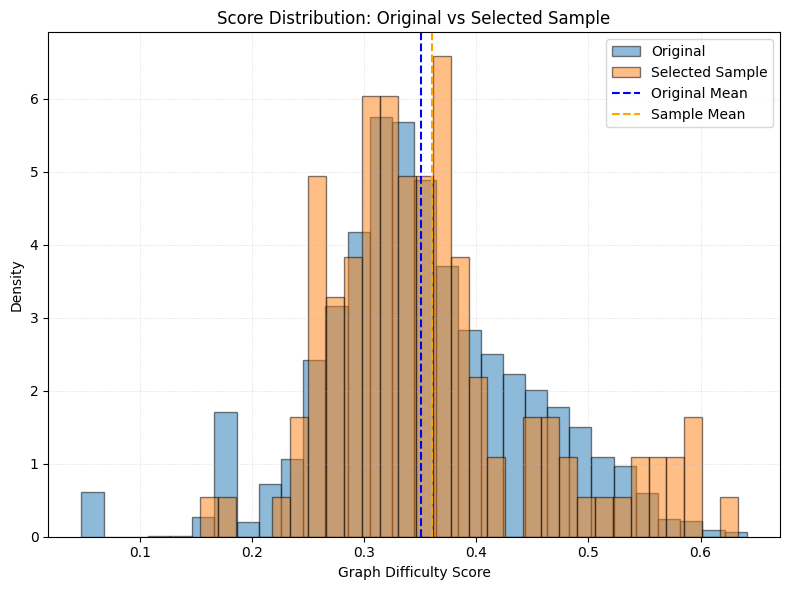

In [20]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 6))
plt.hist(full_keep['complexity'], bins=30, alpha=0.5,
         label='Original', density=True, edgecolor='black')
plt.hist(selected['complexity'], bins=30, alpha=0.5,
         label='Selected Sample', density=True, edgecolor='black')
plt.axvline(full_keep['complexity'].mean(),
            color='blue', linestyle='--', label='Original Mean')
plt.axvline(selected['complexity'].mean(),
            color='orange', linestyle='--', label='Sample Mean')
plt.legend()
plt.title("Score Distribution: Original vs Selected Sample")
plt.xlabel("Graph Difficulty Score")
plt.ylabel("Density")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

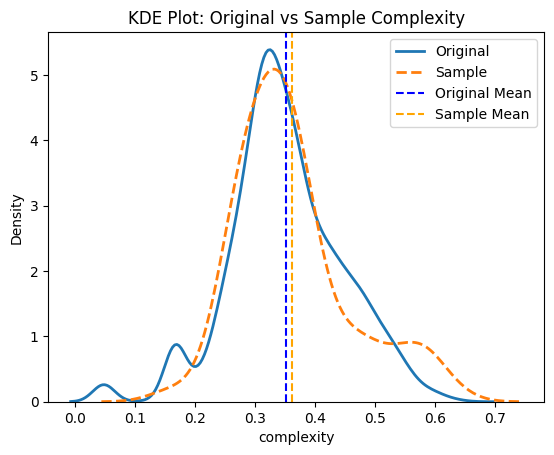

In [21]:
import seaborn as sns

sns.kdeplot(full_keep['complexity'], label="Original", linewidth=2)
sns.kdeplot(selected['complexity'], label="Sample", linestyle="--", linewidth=2)
plt.axvline(full_keep['complexity'].mean(), color='blue', linestyle='dashed', label='Original Mean')
plt.axvline(selected['complexity'].mean(), color='orange', linestyle='dashed', label='Sample Mean')
plt.legend()
plt.title("KDE Plot: Original vs Sample Complexity")
plt.show()
